In [1]:
from fastai.conv_learner import *
from fastai.dataset import *
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
import math

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [35]:
#MODEL_PATH = 'Resnet18_v1'
TRAIN = './input/train/'
TEST = './input/test/'
LABELS = './input/train.csv'
SAMPLE_SUB = './input/sample_submission.csv'

#MODEL_PATH = 'Resnet18_v1'
TRAIN_SRC = './input/train/'
TEST_SRC = './input/test/'
LABELS = './input/train.csv'
SAMPLE_SUB = './input/sample_submission.csv'
#TRAIN = "./input/tmp/train/"
#TEST = "./input/tmp/test/"
TRAIN1 = "./input/tmp1/train/"
TEST1 = "./input/tmp1/test/"




In [3]:
arch = resnet18
nw = 8

In [4]:
train_df = pd.read_csv(LABELS).set_index('Image')
unique_labels = np.unique(train_df.Id.values)
labels_dict = dict()
labels_list = []
for i in range(len(unique_labels)):
    labels_dict[unique_labels[i]] = i
    labels_list.append(unique_labels[i])
print("Number of classes: {}".format(len(unique_labels)))
train_names = train_df.index.values
train_df.Id = train_df.Id.apply(lambda x: labels_dict[x])
train_labels = np.asarray(train_df.Id.values)
test_names = [f for f in os.listdir(TEST)]

Number of classes: 5005


In [5]:
labels_count = train_df.Id.value_counts()
dup = []
for idx,row in train_df.iterrows():
    if labels_count[row['Id']] < 5:
        dup.extend([idx]*math.ceil((5 - labels_count[row['Id']])/labels_count[row['Id']]))
train_names = np.concatenate([train_names, dup])
train_names = train_names[np.random.RandomState(seed=42).permutation(train_names.shape[0])]


## Data analysis

So most of the classes have only one or two sample(s), making train_test_split directly on the data impossible. We'll try a simple fix by duplicating the minor classes so that each class have a minimum of 5 samples.

Count for class new_whale: 9664
41589
41589


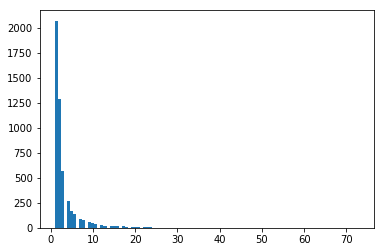

In [6]:
plt.hist(labels_count[1:],bins=100)
print("Count for class new_whale: {}".format(labels_count[0]))
print(len(train_names))
print(len(train_names))

## Data prepare

In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42069)

In [8]:
split = sss.split(train_names, np.zeros(train_names.shape))
train_indexes = []
val_indexes = []
for train_idx, val_idx in sss.split(train_names, np.zeros(train_names.shape)):
    train_indexes = train_idx
    val_indexes = val_idx

In [9]:
print(len(train_indexes), len(val_indexes))

33271 8318


In [10]:
tr_n = [train_names[i] for i in train_indexes]
val_n = [train_names[i] for i in val_indexes]

In [11]:
print(len(tr_n), len(val_n))

33271 8318


In [12]:
#labels = pd.read_csv(LABELS)
#labels["Id"]

In [20]:
avg_width = 0
avg_height = 0
images_widths = []
images_heights = []
for fn in os.listdir(TRAIN)[:1000]:
    img = cv2.imread(os.path.join(TRAIN,fn))
    images_widths.append(img.shape[1])
    images_heights.append(img.shape[0])
avg_width = int(np.mean(images_widths))
avg_height = int(np.mean(images_heights))
print(avg_width, avg_height)

992 512


In [14]:
#val_n[:100]

In [13]:
class HWIDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.train_df = train_df
        super().__init__(fnames, transform, path)

    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        # We crop the center of the original image for faster training time
        img = cv2.resize(img, (self.sz, self.sz))
        return img

    def get_y(self, i):
        if (self.path == TEST or self.path == TEST1 or self.path == TEST_SRC): return 0
        return self.train_df.loc[self.fnames[i]]['Id']


    def get_c(self):
        return len(unique_labels)

In [27]:
def get_data(sz, bs):
    aug_tfms = [RandomRotateZoom(deg=20, zoom=2, stretch=1),
                RandomLighting(0.05, 0.05),
                RandomCrop(sz),
                RandomBlur(blur_strengths=3),
                RandomFlip()]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
    ds = ImageData.get_ds(HWIDataset, (tr_n[:-(len(tr_n) % bs)], TRAIN),
                          (val_n, TRAIN), tfms, test=(test_names, TEST))
    md = ImageData("./", ds, bs, num_workers=nw, classes=None)
    return md

## Learner

In [28]:
batch_size = 64
md = get_data(avg_width//4, batch_size)

In [29]:
learn = ConvLearner.pretrained(arch, md, ps=0.5) 
learn.opt_fn = optim.Adam

### Find Lr

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 5e-2

In [ ]:
learn.fit(lr, 1, cycle_len=2)

In [ ]:
learn.save("first_trainings")

### Load and start

In [21]:
#learn.load("resnet19_im_4_20_16_cyc_1")
#learn.load("resnet19_1_20_16")

In [19]:
learn.unfreeze()

NameError: name 'learn' is not defined

In [ ]:
lrs = np.array([lr/10, lr/20, lr/40])

In [ ]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20, 16))

In [ ]:
learn.save("resnet19_1_20_16")

### Day 1 - get to 0.30 acc

In [22]:
learn.load("acc_0_30_tta_subm1")

In [ ]:
learn.fit(lrs, 2, cycle_len=4, use_clr=(20, 16), cycle_save_name="resnet19_im_4_20_16")

In [ ]:
learn.save("acc_0_30_tta_subm1")

In [ ]:
def predict_and_save(pred_file) :
    preds_t,y_t = learn.TTA(is_test=True,n_aug=8)
    preds_t = np.stack(preds_t, axis=-1)
    preds_t = np.exp(preds_t)
    preds_t = preds_t.mean(axis=-1)
    sample_df = pd.read_csv(SAMPLE_SUB)
    sample_list = list(sample_df.Image)
    pred_list = [[labels_list[i] for i in p.argsort()[-5:][::-1]] for p in preds_t]
    pred_dic = dict((key, value) for (key, value) in zip(learn.data.test_ds.fnames,pred_list))
    pred_list_cor = [' '.join(pred_dic[id]) for id in sample_list]
    df = pd.DataFrame({'Image':sample_list,'Id': pred_list_cor})
    df.to_csv(pred_file, header=True, index=False)
    return df

def submit_to_kaggle(pred_file, message):
    !kaggle competitions submit -c humpback-whale-identification -f {pred_file} -m \"{message}\"

In [ ]:
df = predict_and_save("submission.csv")
df.head()

In [ ]:
submit_to_kaggle("submission.csv", "1st")

### Day 2 - aim for 0.38 acc

In [28]:
learn.load("acc_0_30_tta_subm1")
learn.unfreeze()

 74%|███████▎  | 382/519 [03:16<00:50,  2.71it/s, loss=19.8]

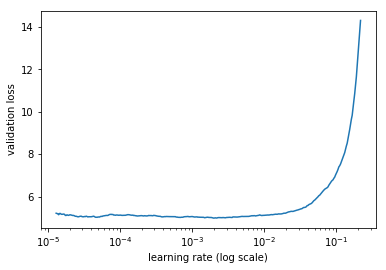

In [23]:
learn.lr_find()

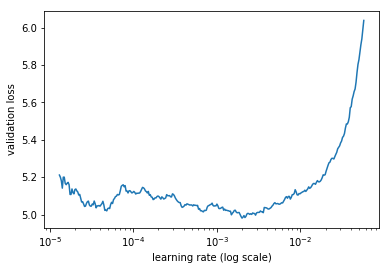

In [27]:
learn.sched.plot(n_skip_end=55)

In [31]:
lr = 5e-4
lrs = np.array([lr/50, lr/5, lr])

In [32]:
learn.fit(lrs, 1, cycle_len=1, use_clr=(20, 10), cycle_save_name="3_resnet19_im_4_20_10")

epoch      trn_loss   val_loss   accuracy                    
    0      5.299536   7.42933    0.297788  


[7.4293297906138624, 0.2977879297048262]

In [33]:
learn.fit(lrs, 1, cycle_len=2, use_clr=(10, 5), cycle_save_name="4_resnet19_im_4_20_10")

epoch      trn_loss   val_loss   accuracy                    
    0      5.210281   7.348099   0.303078  
    1      5.055032   7.265598   0.307285                    


[7.265598006705935, 0.3072854051741306]

In [35]:
data = get_data(400,32)

In [36]:
learn.set_data(data)

In [37]:
learn.unfreeze()

In [39]:
learn.freeze_to(-1)

In [40]:
learn.fit(lrs, 1, cycle_len=2, use_clr=(10, 5), cycle_save_name="5_resnet19_im_4_20_10")

epoch      trn_loss   val_loss   accuracy                     
    0      5.896492   5.873581   0.254749  
    1      5.78574    6.070103   0.255951                     


[6.070102691191783, 0.2559509498048614]

In [41]:
learn.unfreeze()
learn.freeze_to(2)

In [42]:
lr = 5e-3
lrs = np.array([lr/50, lr/5, lr])
learn.fit(lrs, 1, cycle_len=2, use_clr=(10, 5), cycle_save_name="6_resnet19_im_4_20_10")

epoch      trn_loss   val_loss   accuracy                     
    0      5.831699   7.142227   0.261     
    1      4.831007   4.803642   0.305963                     


[4.803641574375329, 0.3059629719183978]

In [43]:
learn.fit(lrs, 1, cycle_len=2, use_clr=(10, 5), cycle_save_name="7_resnet19_im_4_20_10")

epoch      trn_loss   val_loss   accuracy                     
    0      5.13169    5.375348   0.295744  
    1      4.129445   4.271421   0.363429                     


[4.271421332747984, 0.3634287088528996]

In [45]:
lr = 5e-4
lrs = np.array([lr/50, lr/5, lr])

In [46]:
learn.fit(lrs, 1, cycle_len=2, use_clr=(10, 5), cycle_save_name="8_resnet19_im_4_20_10")

epoch      trn_loss   val_loss   accuracy                     
    0      4.589053   4.982277   0.306203  
    1      4.392792   5.085818   0.311373                     


[5.085817570352703, 0.31137292621284185]

In [20]:
learn.load("8_resnet19_im_4_20_10_cyc_0")
learn.unfreeze()

In [21]:
lr = 5e-5
lrs = np.array([lr/100, lr/10, lr])

In [22]:
learn.fit(lrs, 1, cycle_len=2, use_clr=(20, 10), cycle_save_name="9_resnet19_im_4_20_10")

epoch      trn_loss   val_loss   accuracy                    
    0      4.49616    5.440004   0.315581  
    1      4.324825   5.977707   0.319788                    



[5.977706729978803, 0.3197884105824885]

In [23]:
data = get_data(400,32)
learn.set_data(data)

In [25]:
lr = 5e-4
lrs = np.array([lr/100, lr/10, lr])
learn.fit(lrs, 1, cycle_len=2, use_clr=(20, 10), cycle_save_name="10_resnet19_im_4_20_10")

epoch      trn_loss   val_loss   accuracy                     
    0      4.643831   5.147662   0.303198  
    1      4.514487   4.855715   0.313296                     



[4.855714789030786, 0.31329646552517654]

In [84]:
learn.load("7_resnet19_im_4_20_10_cyc_0")

In [85]:
data = get_data_aug(500,32)
learn.set_data(data)

In [29]:
lr = 5e-3
lrs = np.array([lr/50, lr/5, lr])

In [31]:
data = get_data(400,32)
learn.set_data(data)

In [32]:
def predict_and_save(pred_file) :
    preds_t,y_t = learn.TTA(is_test=True,n_aug=8)
    preds_t = np.stack(preds_t, axis=-1)
    preds_t = np.exp(preds_t)
    preds_t = preds_t.mean(axis=-1)
    sample_df = pd.read_csv(SAMPLE_SUB)
    sample_list = list(sample_df.Image)
    pred_list = [[labels_list[i] for i in p.argsort()[-5:][::-1]] for p in preds_t]
    pred_dic = dict((key, value) for (key, value) in zip(learn.data.test_ds.fnames,pred_list))
    pred_list_cor = [' '.join(pred_dic[id]) for id in sample_list]
    df = pd.DataFrame({'Image':sample_list,'Id': pred_list_cor})
    df.to_csv(pred_file, header=True, index=False)
    return df

def submit_to_kaggle(pred_file, message):

    !kaggle competitions submit -c humpback-whale-identification -f {pred_file} -m "{message}"

In [34]:
df = predict_and_save("submission1.csv")
df.head()

,Image,Id
0,00028a005.jpg,new_whale w_778e474 w_5a2634c w_5e8e218 w_dec7ffd
1,000dcf7d8.jpg,new_whale w_dec7ffd w_7b989fb w_c875e45 w_596c806
2,000e7c7df.jpg,new_whale w_2f5caa9 w_dee1053 w_4689352 w_c6c60c8
3,0019c34f4.jpg,new_whale w_9c506f6 w_59052ad w_08630fd w_0135f5f
4,001a4d292.jpg,new_whale w_3d67c3b w_9e18daa w_2a946f2 w_3ef0017


In [37]:
FileLink("submission1.csv")

/home/ubuntu/whales/submission1.csv

In [38]:
#submit_to_kaggle("submission1.csv", "second submission")
!kaggle competitions submit -c humpback-whale-identification -f submission1.csv -m "second"

100%|█████████████████████████████████████████| 498k/498k [00:02<00:00, 186kB/s]
Successfully submitted to Humpback Whale Identification

In [30]:
learn.load("10_resnet19_im_4_20_10_cyc_0")

In [31]:
data = get_data(400,32)
learn.set_data(data)

In [36]:
learn.lr_find()

 68%|██████▊   | 706/1039 [05:27<02:19,  2.38it/s, loss=17.2]

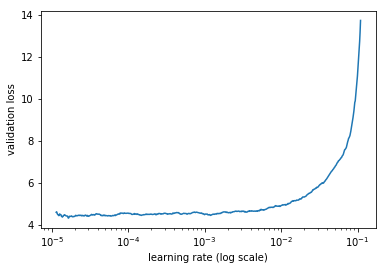

In [37]:
learn.sched.plot()

In [38]:
data = get_data(400,48)
learn.set_data(data)

In [40]:
lr = 5e-5
lrs = np.array([lr/100, lr/10, lr/2])
learn.fit(lrs, 1, cycle_len=2, use_clr=(20, 10), cycle_save_name="11_resnet19_im_4_20_10")

epoch      trn_loss   val_loss   accuracy                    
    0      4.38168    4.822256   0.315941  
    1      4.460079   4.960941   0.314378                    


[4.960941006742323, 0.3143784656393382]

In [45]:
def get_data_aug(sz, bs):
    aug_tfms = [RandomRotate(deg=30),
                RandomZoom(2),
                RandomCrop(sz),
                RandomFlip()]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.RANDOM, aug_tfms=aug_tfms)
    ds = ImageData.get_ds(HWIDataset, (tr_n[:-(len(tr_n) % bs)], TRAIN),
                          (val_n, TRAIN), tfms, test=(test_names, TEST))
    md = ImageData("./", ds, bs, num_workers=nw, classes=None)
    return md

In [42]:
learn.unfreeze()

In [43]:
learn.freeze_to(2)

In [51]:
learn.set_data(get_data_aug(256,48))

In [52]:
lr = 5e-5
lrs = np.array([lr/100, lr/10, lr/2])

In [49]:
learn.fit(lrs, 2, cycle_len=2, use_clr=(10, 5), cycle_save_name="12_resnet19_im_4_20_10")

epoch      trn_loss   val_loss   accuracy                    
    0      5.73412    5.392563   0.300673  
    1      5.694987   5.292472   0.29875                     
    2      5.711766   5.057778   0.29911                     
    3      5.625082   5.196982   0.298389                    


[5.196981538972994, 0.29838904511272174]

In [53]:
learn.set_data(get_data_aug(256,48))

In [54]:
lr = 1e-4
lrs = np.array([lr/10, lr/5, lr])

In [64]:
children(learn.model)[4].p = 0.1

In [86]:
learn.freeze_to(-1)

In [87]:
learn.fit(1e-5, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      5.223393   4.166851   0.362948  


[4.166850732192021, 0.3629478240319816]

In [89]:
learn.unfreeze()
learn.freeze_to(-2)
lr = 5e-6
lrs = np.array([lr/50, lr/10, lr])
learn.fit(lrs, 1, cycle_len=1, use_clr=(10, 5), cycle_save_name="d3_resnet19_im_4_10_5")

epoch      trn_loss   val_loss   accuracy                     
    0      5.536394   5.240704   0.316422  


[5.240703754741488, 0.3164222169363834]

In [76]:
preds = learn.predict(is_test=True)

In [80]:
data.test_ds

['a82ba2f76.jpg',
 'ab62db5a5.jpg',
 '6219200df.jpg',
 '0f3c1f2ca.jpg',
 '7d139670e.jpg',
 '5cf8f9089.jpg',
 '246a3b660.jpg',
 'fac382a8a.jpg',
 '6b37a5e9e.jpg',
 '744caf1ad.jpg',
 'e3abe8153.jpg',
 '99e6e5232.jpg',
 '77f0220dd.jpg',
 'c26fa8510.jpg',
 '4956abeca.jpg',
 'd6412a2a1.jpg',
 '395c2748c.jpg',
 'e7c9ba511.jpg',
 'b46b73a6f.jpg',
 'd9b6e9293.jpg',
 '37683d93d.jpg',
 '8437fe93d.jpg',
 'a34810714.jpg',
 '36d2df14c.jpg',
 'c303faac6.jpg',
 '4ab6eb239.jpg',
 '430c15a2b.jpg',
 'ee7e05813.jpg',
 '4961607e0.jpg',
 'feb0dbc4a.jpg',
 'b54ed95e0.jpg',
 '1d596e1d0.jpg',
 '4f8eec727.jpg',
 '534704661.jpg',
 '4acb90694.jpg',
 '86be3cb18.jpg',
 'cf045caf2.jpg',
 '88495a329.jpg',
 'dbce31605.jpg',
 'd94bb20e9.jpg',
 '4a018dac2.jpg',
 '5ab7f8a5c.jpg',
 'a8a18fd1a.jpg',
 '5a3a7c007.jpg',
 'f6500c021.jpg',
 'dfc41c3ce.jpg',
 '36b7fc036.jpg',
 'b3c58e7b9.jpg',
 '9bf5c23f1.jpg',
 '497a8fed2.jpg',
 '2aeee8b9f.jpg',
 'efac7e263.jpg',
 '2ef297872.jpg',
 '009dd6c96.jpg',
 'a0d962939.jpg',
 'ab9b6d8d

In [83]:
accuracy(preds, data)

TypeError: max() received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (Tensor input)
 * (Tensor input, Tensor other, Tensor out)
 * (Tensor input, int dim, bool keepdim, tuple of Tensors out)


In [68]:
learn.unfreeze()

In [72]:
learn.freeze_to(-2)

In [73]:
learn.fit(1e-4, 1)

 19%|█▉        | 134/693 [01:01<04:01,  2.32it/s, loss=4.46]

KeyboardInterrupt: 

In [ ]:
learn.fit(lrs, 2, cycle_len=2, use_clr=(10, 5), cycle_save_name="12_resnet19_im_4_20_10")